<a href="https://colab.research.google.com/github/rajy4683/S11EVA4/blob/master/S11EVA4_CLR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Sun Apr  5 19:37:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### Downloading and installing dependencies from the GitHub link:


In [0]:
!git clone https://github.com/rajy4683/RekogNizer.git /content/drive/My\ Drive/EVA4/RekogNizer

In [3]:
!pip install -r /content/drive/My\ Drive/EVA4/RekogNizer/requirements.txt

In [4]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-1ejoq3x8
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-1ejoq3x8
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65100 sha256=6e6b3cf4f925881d4a99200178cc0daf4239b55f0154f4f47468c97e8a1c27d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-eqlmkr2m/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


#### WANDB client login

In [5]:
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
sys.path.append('/content/drive/My Drive/EVA4/')
sys.path.append('/content/drive/My Drive/EVA4/RekogNizer')

### Cutout + Horizontal Flip + MotionBlur

In [0]:
from RekogNizer import train_s9_new

In [0]:
%load_ext autoreload

In [9]:
%autoreload 2
from RekogNizer import lrfinder
from RekogNizer import traintest
from RekogNizer import logger
from RekogNizer import fileutils
from RekogNizer import basemodelclass
from RekogNizer import dataloader

from torchsummary import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Cutout, MotionBlur
from albumentations import (
    HorizontalFlip, Compose, RandomCrop, Cutout,Normalize, HorizontalFlip, RandomBrightnessContrast,
    Resize,RandomSizedCrop, MotionBlur,MultiplicativeNoise,InvertImg,PadIfNeeded,Flip
)
from albumentations.pytorch import ToTensor


from RekogNizer import hyperparams
hyper_param_values = {
                      "lr":0.21694816106338752,
                      "dropout":0.1, 
                      "momentum":0.7062620648684866, 
                      "epochs":100, 
                      "weight_decay":0.00015753761358641488
                      }
hyperparams.set_hyperparam(hyper_param_values)
torch.manual_seed(hyperparams.hyperparameter_defaults['seed'])    


Files already downloaded and verified
Files already downloaded and verified
torch.Size([128, 3, 32, 32]) tensor([-0.0411, -0.0410, -0.0133]) tensor([0.9705, 0.9939, 0.9879])


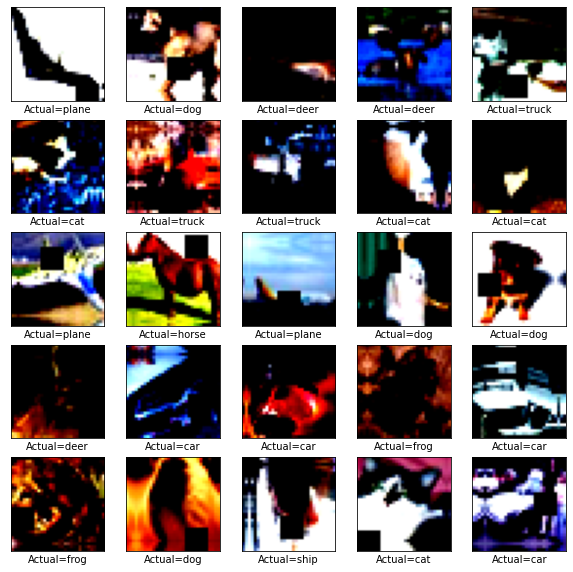

In [10]:
transform_train = Compose([
    #Cutout(num_holes=1,max_h_size=16,max_w_size=16,always_apply=True,p=1,fill_value=[0.5268*255, 0.5267*255, 0.5328*255]),
    PadIfNeeded(min_height=40,min_width=40, always_apply=True, p=1.0),
    RandomCrop(height=32,width=32, p=1),
    Flip(p=0.5),
    Cutout(num_holes=1,max_h_size=8,max_w_size=8,always_apply=True,p=1,fill_value=[0.4914*255, 0.4826*255, 0.44653*255]),
    #Cutout(num_holes=1,max_h_size=16,max_w_size=16,always_apply=True,p=1,fill_value=[0.4819*255, 0.4713*255, 0.4409*255]),
    #MotionBlur(blur_limit=7, always_apply=True, p=1),
    #RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, always_apply=True, p=1),
    #MultiplicativeNoise(multiplier=1.5, p=1),
    #InvertImg(p=0.5),
    #HorizontalFlip(p=1),
    Normalize(
      mean=[0.4914, 0.4826, 0.44653],
      std=[0.24703, 0.24349, 0.26519],
      ),
    # Normalize(
    #    mean=[0.5268, 0.5267, 0.5328],
    #    std=[0.3485, 0.3444, 0.3447],
    #    ),
    
    ToTensor()
    ])
trainloader, testloader = dataloader.get_train_test_dataloader_cifar10(transform_train=transform_train)

torch.manual_seed(1)
dataiter = iter(trainloader)
images, labels = dataiter.next()

fileutils.show_sample_images(images,labels, dataloader.classes)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
 ModifiedResBlock-14          [-1, 128,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
Min loss:0.9510637179277363 Min LR:0.24343501419733785 Max LR:1.8669514186394633
LR plotting in progress


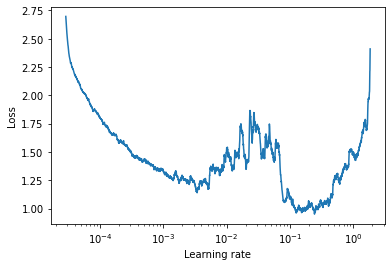

(0.9510637179277363, 0.24343501419733785, 1.8669514186394633)

In [11]:
%autoreload 1
from RekogNizer import dataloader
from RekogNizer import traintest
from RekogNizer import basemodelclass
#model_new = basemodelclass.ResNet18(hyperparams.hyperparameter_defaults['dropout'])
model_new = basemodelclass.S11ResNet()
summary(model_new.to(torch.device("cuda")),input_size=(3, 32, 32))


torch.manual_seed(1)
criterion = nn.CrossEntropyLoss()
##3.279445101495624
#0.30585674609910773
#optimizer = optim.SGD(model_new.parameters(), lr=0.279445101495624, weight_decay=0.00020996378493752516,momentum=0.42786879879874073)#-->89.43


optimizer = optim.SGD(model_new.parameters(), lr=0.0000279445101495624, weight_decay=0.0,momentum=0.9)

#traintest.find_lr_type1(model_new, optimizer, criterion, trainloader, seed=1)
traintest.find_lr_type1(model_new, optimizer, criterion, trainloader, seed=1,num_iter=5000)

In [0]:

optimizer = optim.SGD(model_new.parameters(), lr=0.0279445101495624, weight_decay=0.00020996378493752516,momentum=0.42786879879874073)#-->89.43

traintest.find_lr_type2(model_new, optimizer, criterion, trainloader, testloader, seed=1)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
Min loss:2.303268256664276 Min LR:0.035719683826315234 Max LR:0.13228182132922237
LR plotting in progress


In [12]:
!python  /content/drive/My\ Drive/EVA4/RekogNizer/train_s11_new.py -p '{"lr":0.24343501419733785, "momentum":0.9, "epochs":24, "weight_decay":0.0,"batch_size":512}'

  pip install torch-lr-finder -v --global-option="amp"
Setting  lr  =  0.24343501419733785
Setting  momentum  =  0.9
Setting  epochs  =  24
Setting  weight_decay  =  0.0
Setting  batch_size  =  512
Final Hyperparameters
             dropout : 0.1 
          batch_size : 512 
     test_batch_size : 128 
                  lr : 0.24343501419733785 
            momentum : 0.9 
             no_cuda : False 
                seed : 1 
              epochs : 24 
                bias : False 
      sched_lr_gamma : 0.5 
       sched_lr_step : 1 
            start_lr : 0 
        weight_decay : 0.0 
  lr_decay_threshold : 0.0 
              factor : 0.0 
             project : news5 
Files already downloaded and verified
Files already downloaded and verified
Initializing datasets and dataloaders
wandb: Tracking run with wandb version 0.8.31
wandb: Run data is saved locally in wandb/run-20200405_194319-1imd5vjd
wandb: Syncing run rare-grass-945
wandb: ⭐️ View project at https://app.wandb.ai/rajy4

In [13]:
!python  /content/drive/My\ Drive/EVA4/RekogNizer/train_s11_new.py -p '{"lr":0.24343501419733785, "momentum":0.9, "epochs":24, "weight_decay":0.0,"batch_size":512}'

  pip install torch-lr-finder -v --global-option="amp"
Setting  lr  =  0.24343501419733785
Setting  momentum  =  0.9
Setting  epochs  =  24
Setting  weight_decay  =  0.0
Setting  batch_size  =  512
Final Hyperparameters
             dropout : 0.1 
          batch_size : 512 
     test_batch_size : 128 
                  lr : 0.24343501419733785 
            momentum : 0.9 
             no_cuda : False 
                seed : 1 
              epochs : 24 
                bias : False 
      sched_lr_gamma : 0.5 
       sched_lr_step : 1 
            start_lr : 0 
        weight_decay : 0.0 
  lr_decay_threshold : 0.0 
              factor : 0.0 
             project : news5 
Files already downloaded and verified
Files already downloaded and verified
Initializing datasets and dataloaders
wandb: Tracking run with wandb version 0.8.31
wandb: Run data is saved locally in wandb/run-20200405_195606-2a6p6f1q
wandb: Syncing run fearless-dust-946
wandb: ⭐️ View project at https://app.wandb.ai/ra

#### The APIs for inferencing and plotting are moved out of the training script.


In [0]:
from RekogNizer import traintest
from RekogNizer import logger
from RekogNizer import fileutils
from RekogNizer import basemodelclass
from RekogNizer import dataloader

import pandas as pd
import numpy as np
import torch

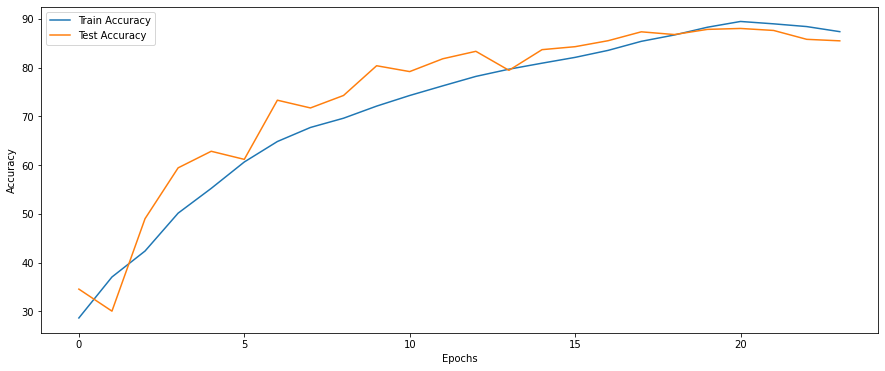

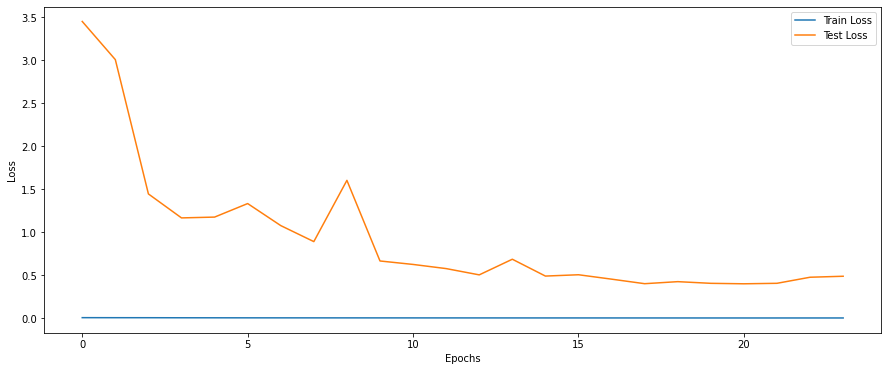

In [15]:
run_list = ['rajy4683/news5/runs/2a6p6f1q']
runs_df = logger.get_wandb_dataframes(run_list=run_list)#(project="rajy4683/news5",count=1)
new_df = pd.DataFrame().append(runs_df)


fileutils.plot_graphs([new_df],
            ['Train Accuracy', 'Test Accuracy'],
            columns=['Train Accuracy', 'Test Accuracy'],
            xlabel="Epochs",
            ylabel="Accuracy")

fileutils.plot_graphs([new_df],
            ['Train Loss', 'Test Loss'],
            columns=['Train Loss', 'Test Loss'],
            xlabel="Epochs",
            ylabel="Loss")

In [16]:
%load_ext autoreload
%autoreload 2
from RekogNizer import traintest
import torchvision.transforms as transforms
import torchvision

#my_model,acc = traintest.model_builder2(basemodelclass.ResNet18(), weights_path="/content/drive/My Drive/EVA4/model_saves/model-23b3505819.h5")
#my_model,acc = traintest.model_builder2(basemodelclass.ResNet18(), weights_path="/content/drive/My Drive/EVA4/model_saves/model-15ad50e1bc.h5", local_device=torch.device("cpu"))
#my_model,acc = traintest.model_builder2(basemodelclass.ResNet18(), weights_path="/content/drive/My Drive/EVA4/model_saves/model-2fba2384bd.h5", local_device=torch.device("cpu"))
my_model,acc = traintest.model_builder2(basemodelclass.S11ResNet(), weights_path="/content/drive/My Drive/EVA4/model_saves/model-8ee5612a40.h5", local_device=torch.device("cpu"))

#class_accuracy_dict = traintest.classwise_accuracy(my_model, testloader, classes, device=torch.device("cpu"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from RekogNizer import hyperparams
# transform_test = transforms.Compose(
#     [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                     download=True, transform=transform_test)
# testloader = dataloader.get_dataloader(testset, hyperparams.hyperparameter_defaults['batch_size'], shuffle=False, num_workers=2)

trainloader, testloader = dataloader.get_train_test_dataloader_cifar10()

class_accuracy_dict = traintest.classwise_accuracy(my_model, testloader, dataloader.classes, device=torch.device("cuda"))

Files already downloaded and verified
Files already downloaded and verified
Accuracy of plane : 90 %
Accuracy of   car : 95 %
Accuracy of  bird : 83 %
Accuracy of   cat : 74 %
Accuracy of  deer : 89 %
Accuracy of   dog : 82 %
Accuracy of  frog : 91 %
Accuracy of horse : 92 %
Accuracy of  ship : 93 %
Accuracy of truck : 91 %


<BarContainer object of 10 artists>

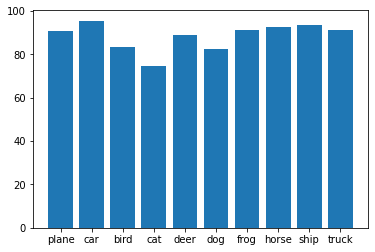

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar([key for key in class_accuracy_dict.keys()],[val for val in class_accuracy_dict.values()])

Files already downloaded and verified
Files already downloaded and verified
1160
(1160,)
88.4 0.3728220814704895


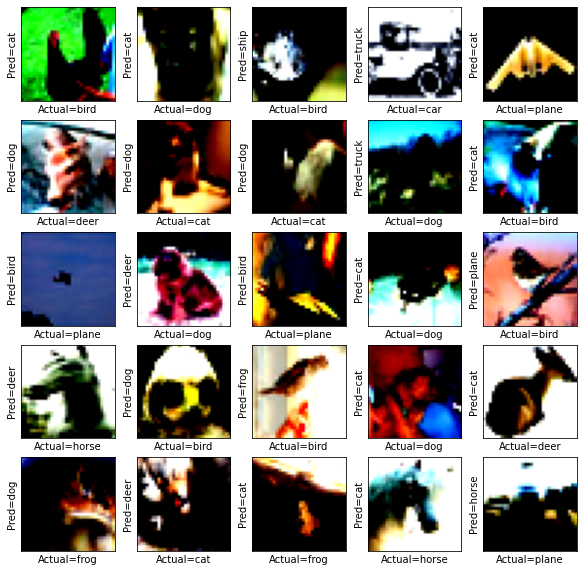

In [19]:
from RekogNizer import traintest
type(my_model)
classes = dataloader.classes
trainloader, testloader = dataloader.get_train_test_dataloader_cifar10()
error_images, preds, actuals = traintest.show_misclassfied_images(my_model, testloader, dataloader.classes)


# GRADCAM Visualizations

In [0]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

from RekogNizer.gradcam2 import *

saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])


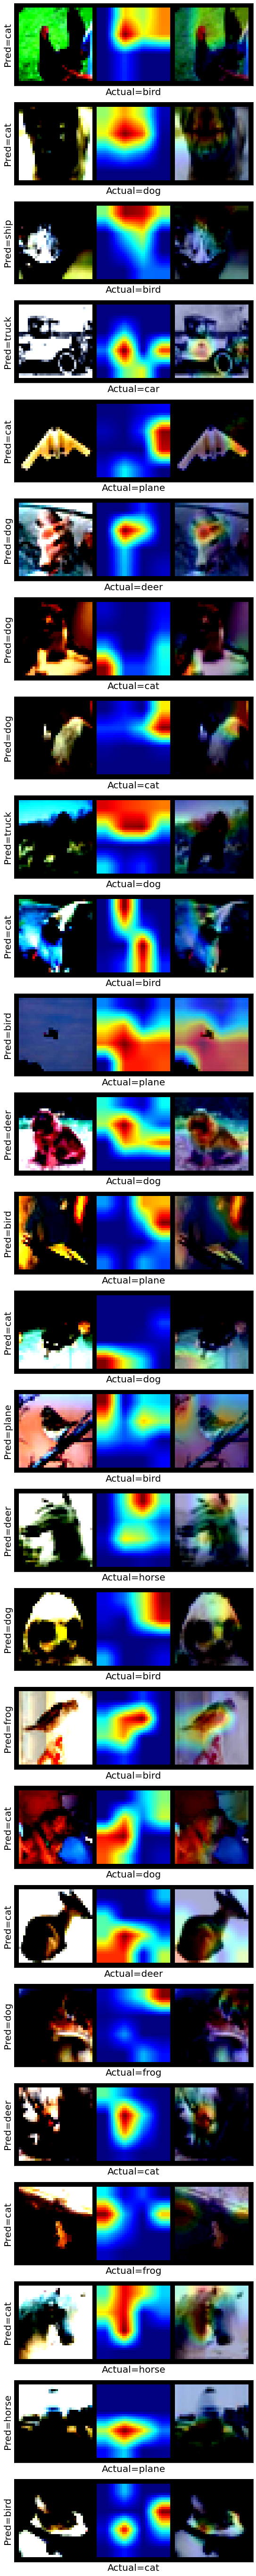

In [21]:
resnet_model_dict = dict(type='resnet', arch=my_model.to(torch.device("cpu")), layer_name='layer3', input_size=(32, 32))
mean=[0.4827, 0.4724, 0.4427]
std=[0.2482, 0.2501, 0.2698]

#classes[np.int(preds[idx])], xlabel="Actual="+classes[np.int(actuals[idx])]
classes = dataloader.classes

#gradcam_images = []
fig = plt.figure(figsize=(100,100))
idx = 0
for elem in zip(error_images[:26], actuals[:26], preds[:26]):
    ax = fig.add_subplot(26, 1, idx+1, xticks=[], yticks=[])
    idx+=1
    npimg= visualize_gradcam_image(resnet_model_dict,
                            elem[0], 
                            classes[np.int(elem[1])], 
                            classes[np.int(elem[2])], 
                            mean=mean, std=std)
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_xlabel(xlabel="Actual="+classes[np.int(elem[1])],fontsize=20)
    ax.set_ylabel(ylabel="Pred="+classes[np.int(elem[2])],fontsize=20)
                  #xlabel="Actual="+classes[np.int(elem[1])],fontdict=)
fig.savefig('/content/drive/My Drive/EVA4/gradcam_s10eva4.jpg')